This notebook is to explore the code within RITSAR. For ease of exploration, instead of importing the RITSAR package, the needed components for the original AFRL tutorial are copied here as classes. Minor modifications can then be made (such as those added to polar format below) to add reporting tap points at any point desired. Enjoy!

Note: Changes made to the code in the main RITSAR files may have not propagated here. 

In [1]:
#Include standard library dependencies
import matplotlib.pyplot as plt
%matplotlib notebook
import scipy.io as sio 
import numpy as np

#Include dependencies
from scipy.stats import linregress
from fnmatch import fnmatch
import pathlib
import os
import xml.etree.ElementTree as ET
class phsRead_():
    def __init__(self):
        return None

    def AFRL(self, directory, start_az, pol=False, n_az=3):
        '''
        This function reads in the AFRL *.mat files from the user supplied 
        directory and exports both the phs and a Python dictionary compatible
        with ritsar.

        Parameters
        ----------
        directory : str
            Path to the directory in which your phase history files are housed. If using 'pol'
            this instead houses the polarization files such as 'HH' and 'VV'.
        start_az : int
            AFRL ends its filenames in a number. I haven't quite figured out what the number 
            means yet. But for the user it means which file in the folder you want to start with.
        pol : str, optional
            Sub folder which houses the actual data in polarized sets, does not need to be used 
            if you input the direct path in `directory`. 
        n_az : int, optional
            The number of files to join together. I noticed this means something in older data
            but I'm not sure if it has any meaning in newer sets. Default is 1.
        '''

        #Get filenames
        if pol:
            root=pathlib.Path(directory+'/'+pol)
        else:
            root=pathlib.Path(directory)
        items=list(root.glob('*.mat'))
        az=np.arange(start_az, start_az+n_az)
        if pol:
            suffix=[str('%03d_%s.mat'%(a,pol)) for a in az]
        else:
            suffix=[str('%04d.mat'%a) for a in az]
        fnames=[item for item in items if any(s in item.name for s in suffix)]
        self.fnames=fnames

        #Grab n_az phase histories
        phs = []; platform = []
        for fname in sorted(fnames):
            #Convert MATLAB structure to Python dictionary
            data=sio.loadmat(fname, simplify_cells=True)['data']

            #Define phase history
            keys=data.keys()
            key='fp' if 'fp' in keys else 'fq' #Used for compatibility
            phs_tmp     = data[key].T
            phs.append(phs_tmp)

            #Transform data to be compatible with ritsar
            c           = np.float64(299792458.0)
            nsamples    = int(phs_tmp.shape[1])
            npulses     = int(phs_tmp.shape[0])
            freq        = np.float64(data['freq'])
            pos         = np.vstack((data['x'], data['y'], data['z'])).T
            k_r         = 4*np.pi*freq/c
            B_IF        = freq.max()-freq.min()
            delta_r     = c/(2*B_IF)
            delta_t     = 1.0/B_IF
            t           = np.linspace(-nsamples/2, nsamples/2, nsamples)*delta_t

            chirprate, f_0, r, p, s\
                        = linregress(t, freq)

            #Vector to scene center at synthetic aperture center
            if np.mod(npulses,2)>0:
                R_c = pos[npulses//2]
            else:
                R_c = np.mean(
                        pos[npulses//2-1:npulses//2+1],
                        axis = 0)

            #Save values to dictionary for export
            platform_tmp = \
            {
                'f_0'       :   f_0,
                'freq'      :   freq,
                'chirprate' :   chirprate,
                'B_IF'      :   B_IF,
                'nsamples'  :   nsamples,
                'npulses'   :   npulses,
                'pos'       :   pos,
                'delta_r'   :   delta_r,
                'R_c'       :   R_c,
                't'         :   t,
                'k_r'       :   k_r,
                'r0'        :   data['r0'],
                'th'        :   data['th'],
                'phi'       :   data['phi'],
                'filename'  :   fname #added for debugging
            }
            platform.append(platform_tmp)

        #Stack data from different azimuth files
        phs = np.vstack(phs)
        npulses = int(phs.shape[0])
        self.platform=platform #specifically from this spot, because it gets overwritten


        #Stack position, per pulse reference range, theta(degrees), and depression angle
        pos = platform[0]['pos']
        r0  = platform[0]['r0']
        th  = platform[0]['th']
        phi = platform[0]['phi']
        for i in range(1, n_az):
            pos = np.vstack((pos, platform[i]['pos']))
            r0  = np.append(r0,platform[i]['r0'])
            th  = np.append(th,platform[i]['th'])
            phi = np.append(phi,platform[i]['phi'])

        if np.mod(npulses,2)>0:
            R_c = pos[npulses//2]
        else:
            R_c = np.mean(
                    pos[npulses//2-1:npulses//2+1],
                    axis = 0)

        #Replace Dictionary values
        platform = platform_tmp
        platform_update=\
        {
                'npulses'    :   npulses,
                'pos'        :   pos,
                'R_c'        :   R_c,
                'r0'         :   r0,
                'th'         :   th,
                'phi'        :   phi,
        }
        platform.update(platform_update)

        #Synthetic aperture length
        L = np.linalg.norm(pos[-1]-pos[0])

        #Add k_y
        platform['k_y'] = np.linspace(-npulses/2,npulses/2,npulses)*2*np.pi/L

        return(phs, platform)
    
from matplotlib import cm
from scipy.interpolate import interp1d
import multiprocessing as mp    
class imgTools_():
    def __init__(self):
        return None
    
    def img_plane_dict(self, platform, n_hat = np.array([0,0,1]), numPixels=False, \
                       length=False, upsample=False, res_factor=False,
                       aspect=False, checkme=False, force_xy=False):
        '''
        This function defines the image plane parameters.

        Parameters
        ----------
        platform  :  dict    
            The platform dictionary. Must include keys 'nsamples',
            'npulses', 'freq', 'R_c', 'pos' and if keyword `res_factor` is
            used 'delta_r'    
        n_hat  :  array, default=numpy.array([0,0,1])    
            Normal vector of the plane in which you wish to form the image    
        numPixels  :  int, array, tuple, or list. optional
            Allows the user to specify the number of pixels of the output image in
            range(nu) and cross range(nv) directions. int will result in a square.    
        length  :  int, array, tuple, or list. optional    
            Size (m) of scene to form image in range and cross range 
            directions (determined by center of aperture) about scene center.    
        upsample  :  bool, optional    
            Autodetermines image size by rounding nsamples and npulses up 
            to the nearest power of 2. Overridden by numPixels    
        res_factor  :  float, optional    
            A res_factor of 1 yields a (u,v) image plane whose pixels are 
            sized at the theoretical resolution limit of the system derived
            using delta_r which in turn was derived using the bandwidth.
            Using this or aspect will override `length`    
        aspect  :  float, optional    
            Using this will force a given aspect (dv/du) on the output image
            and will select the lower resolution (larger) between du and dv 
            at the given aspect. This will override length    
        checkme  :  bool, optional    
            Prints theoretical maximum scene size and resolution limits.
            Then prints chosen size and resolution limits.    
        force_xy  :  bool, optional    
            Used for comparison with matlab code. Forces u_vec=[1,0,0] and
            v_vec=[0,1,0]. Note that this overrides n_hat    

        Returns
        ----------
        output  :  dict    
            Contains keys: 'n_hat', 'u_hat', 'v_hat', 'du', 'dv', 'u', 'v', 'k_u',
            'k_v', and 'pixel_locs'. 'du'/'dv' (m) represents the spacing along 
            'u' and 'v' while 'u_hat' and 'v_hat' give their direction.'k_u' and 
            'k_v' (1/m) represent frequencies on the image plane. 'pixel_locs' is 
            a 3x(nu,nv) array of xyz coordinates to use for sampling locations.    

        '''
        c           =   299792458.0
        nsamples = platform['nsamples']
        npulses  = platform['npulses']
        freq     = platform['freq']

        if freq.ndim ==1:
            freq=freq[None,:]
        deltaF=freq[0,2]-freq[0,1]

        #Import relevant platform parameters
        R_c = platform['R_c']    
        def isany(x):
            isin=isinstance
            return np.any([isin(x,list),isin(x,np.ndarray),isin(x,tuple)])

        #Define image plane parameters
        if isany(numPixels):
            nu,nv=numPixels[0],numPixels[-1]
        elif np.all([isinstance(numPixels,int),numPixels>0]):
            nu,nv=numPixels,numPixels
        elif np.all([not numPixels,upsample]):
            nu= 2**int(np.log2(nsamples)+bool(np.mod(np.log2(nsamples),1)))
            nv= 2**int(np.log2(npulses)+bool(np.mod(np.log2(npulses),1)))
        else:
            nu,nv= nsamples,npulses

        #Determine scene bounds
        # Determine the azimuth angles of the image pulses (radians)
        pos=platform['pos']
        AntAz = np.unwrap(np.arctan2(pos[:,1],pos[:,0]))

        # Determine the average azimuth angle step size (radians)
        deltaAz = np.abs(np.mean(np.diff(AntAz)))

        # Determine the total azimuth angle of the aperture (radians)
        totalAz = np.max(AntAz) - np.min(AntAz)

        # Determine the maximum scene size of the image (m)
        maxWr = c/(2*deltaF)
        maxWx = c/(2*deltaAz*np.mean(freq[0,:]))

        if isany(length):
            ulength,vlength=length[0],length[-1]
        elif np.all([isinstance(length,int),length>0]):
            ulength,vlength=length,length
        else:
            ulength,vlength=1.22*maxWr,1.22*maxWx #1.22 for Airy disk limit, will alias

        #Build Pixel Grid
        if res_factor: #included for compatibility
            #Define resolution.  This should be less than the system resolution limits
            res_factor=res_factor if res_factor else 1.0
            du = platform['delta_r']*res_factor*nsamples/nu
            aspect=aspect if aspect else 1.0
            dv = aspect*du
            #Define range and cross-range locations
            u = np.arange(-nu/2, nu/2)*du
            v = np.arange(-nv/2, nv/2)*dv
            ulength,vlength=np.abs(u[-1]-u[0]),np.abs(v[-1]-v[0])
        elif np.all([not res_factor, aspect]):
            ubound = 0.5*ulength*np.array([-1, 1]);
            vbound = 0.5*vlength*np.array([-1, 1]);
            du=np.max([ulength/nu,vlength/(aspect*nv)])
            dv=aspect*du
            #Define range and cross-range locations
            u = np.arange(-nu/2, nu/2)*du
            v = np.arange(-nv/2, nv/2)*dv
            ulength,vlength=np.abs(u[-1]-u[0]),np.abs(v[-1]-v[0])
        else:
            ubound = 0.5*ulength*np.array([-1, 1]);
            vbound = 0.5*vlength*np.array([-1, 1]);
            u = np.linspace(ubound[0],ubound[1],nu);
            v = np.linspace(vbound[0],vbound[1],nv);  
            du=u[2]-u[1]
            dv=v[2]-v[1]

        if checkme:
            # Determine the resolution of the image (m)
            dr = c/(2*deltaF*nsamples);
            dx = c/(2*totalAz*np.mean(freq[0,:]));

            # Display maximum scene size and resolution
            print('Maximum Scene Size:  %.4f m range, %.4f m cross-range'%(maxWr,maxWx))
            print('Max Resolution:  %.4fm range, %.4f m cross-range'%(dr,dx))
            print('Chosen Size: %.4f m range %.4f m cross-range' %(ulength,vlength))
            print('Chosen Sample Spacing: %.4f m range, %.4f m cross-range'%(du,dv))

        #Derive image plane spatial frequencies
        k_u = 2*np.pi*np.linspace(-1.0/(2*du), 1.0/(2*du), nu)
        k_v = 2*np.pi*np.linspace(-1.0/(2*dv), 1.0/(2*dv), nv)

        if force_xy:
            u_hat=np.array([1,0,0])
            v_hat=np.array([0,1,0])
        else:
            #Derive representation of u_hat and v_hat in (x,y,z) space
            v_hat = np.cross(n_hat, R_c)/np.linalg.norm(np.cross(n_hat, R_c))
            u_hat = np.cross(v_hat, n_hat)/np.linalg.norm(np.cross(v_hat, n_hat))

        #Represent u and v in (x,y,z)
        [uu,vv] = np.meshgrid(u,v)
        uu = uu.flatten(); vv = vv.flatten()

        A = np.asmatrix(np.hstack((
            np.array([u_hat]).T, np.array([v_hat]).T 
                ))) 
        b = np.asmatrix(np.vstack((uu,vv)))
        pixel_locs = np.asarray(A*b)

        #Construct dictionary and return to caller
        img_plane =\
        {
        'n_hat'     :   n_hat,
        'u_hat'     :   u_hat,
        'v_hat'     :   v_hat,
        'du'        :   du,
        'dv'        :   dv,
        'u'         :   u,
        'v'         :   v,
        'k_u'       :   k_u,
        'k_v'       :   k_v,
        'pixel_locs':   pixel_locs # 3 x N_pixel array specifying x,y,z location
                                   # of each pixel
        }

        return(img_plane)
    
    def polar_format(self, phs, platform, img_plane, taylor = 20, prnt=100):
        # #############################################################################
        #                                                                            #
        #  This is the Polar Format algorithm.  The phase history data as well as    #
        #  platform and image plane dictionaries are taken as inputs.                #
        #                                                                            #
        #  The phase history data is collected on a two-dimensional surface in       #
        #  k-space.  For each pulse, a strip of this surface is collected.  The      #
        #  first step in this program is to project each strip onto the (ku,kv)      #
        #  plane defined by the normal vector contained in the image plane           #
        #  dictionary.  This will result in data that is unevenly spaced in (ku,kv). # 
        #  This unevenly spaced data is interpolated onto an evenly spaced (ku,kv)   #
        #  grid defined in the image plane dictionary.  The interpolation is done    #
        #  along the radial direction first, then along the along-track direction.   #
        #  Further details of this method are given in both the Jakowitz and Carrera #
        #  texts.                                                                    #
        #                                                                            #
        # #############################################################################

        #Retrieve relevent parameters
        c           =   299792458.0
        npulses     =   platform['npulses']
        f_0         =   platform['f_0']
        pos         =   np.asarray(platform['pos'])
        k           =   platform['k_r']
        R_c         =   platform['R_c']
        n_hat       =   img_plane['n_hat']
        k_ui        =   img_plane['k_u']
        k_vi        =   img_plane['k_v']

        #Compute k_xi offset
        psi = np.pi/2-np.arccos(np.dot(R_c,n_hat)/np.linalg.norm(R_c))
        k_ui = k_ui + 4*np.pi*f_0/c*np.cos(psi)

        #Compute number of samples in scene
        nu = k_ui.size
        nv = k_vi.size

        #Compute x and y unit vectors. x defined to lie along R_c.
        #z = np.cross(vec[0], vec[-1]); z =z/np.linalg.norm(z)
        u_hat = (R_c-np.dot(R_c,n_hat)*n_hat)/\
                np.linalg.norm((R_c-np.dot(R_c,n_hat)*n_hat))
        v_hat = np.cross(u_hat,n_hat)

        #Compute r_hat, the diretion of k_r, for each pulse
        r_norm = np.linalg.norm(pos,axis=1)
        r_norm = np.array([r_norm]).T
        r_norm = np.tile(r_norm,(1,3))

        r_hat = pos/r_norm

        #Convert to matrices to make projections easier
        r_hat = np.asmatrix(r_hat)
        u_hat = np.asmatrix([u_hat])
        v_hat = np.asmatrix([v_hat])

        k_matrix = np.asmatrix(k)

        #Compute kx and ky meshgrid
        ku = r_hat*u_hat.T*k_matrix; ku = np.asarray(ku)
        kv = r_hat*v_hat.T*k_matrix; kv = np.asarray(kv)

        #Create taylor windows
        win1 = signal.taylor(int(phs.shape[1]), S_L = taylor)
        win2 = signal.taylor(int(phs.shape[0]), S_L = taylor)

        #Radially interpolate kx and ky data from polar raster
        #onto evenly spaced kx_i and ky_i grid for each pulse
        rad_interp = 0j*np.zeros([npulses,nu])
        ky_new = np.zeros([npulses,nu])
        for i in range(npulses):
            if prnt:
                if i%prnt==0:
                    print('range interpolating for pulse %i'%(i+1))
            rad_interp[i,:] = np.interp(k_ui, ku[i,:], phs[i,:]*win1,
                left = 0, right = 0)
            ky_new[i,:] = np.interp(k_ui, ku[i,:], kv[i,:])  

        #Interpolate in along track direction to obtain polar formatted data
        polar = 0j*np.zeros([nv,nu])
        isSort = (ky_new[npulses//2, nu//2] < ky_new[npulses//2+1, nu//2])
        if isSort:
            for i in range(nu):
                if prnt:
                    if i%prnt==0:
                        print('cross-range interpolating for sample %i'%(i+1))
                polar[:,i] = np.interp(k_vi, ky_new[:,i], rad_interp[:,i]*win2,
                    left = 0, right = 0)
        else:
            for i in range(nu):
                if prnt:
                    if i%prnt==0:
                        print('cross-range interpolating for sample %i'%(i+1))
                polar[:,i] = np.interp(k_vi, ky_new[::-1,i], 
                    rad_interp[::-1,i]*win2, left = 0, right = 0)  

        phs_polar=np.nan_to_num(polar)

        img = np.abs(signal.ft2(phs_polar))
        
        #save inner workings for view later
        self.pf_R_c=R_c
        self.pf_uhat=u_hat
        self.pf_vhat=v_hat
        self.pf_ku=ku
        self.pf_kv=kv
        self.pf_ky_new=ky_new
        self.pf_rad_interp=rad_interp
        self.pf_polar=polar

        return(img)
    
    def backprojection(self, phs, platform, img_plane, taylor = 20, upsample = 6, prnt = False):
        ##############################################################################
        #                                                                            #
        #  This is the Backprojection algorithm.  The phase history data as well as  #
        #  platform and image plane dictionaries are taken as inputs.  The (x,y,z)   #
        #  locations of each pixel are required, as well as the size of the final    #
        #  image (interpreted as [size(v) x size(u)]).                               #
        #                                                                            #
        ##############################################################################

        #Retrieve relevent parameters
        nsamples    =   platform['nsamples']
        npulses     =   platform['npulses']
        k_r         =   platform['k_r']
        pos         =   platform['pos']
        delta_r     =   platform['delta_r']
        u           =   img_plane['u']
        v           =   img_plane['v']
        r           =   img_plane['pixel_locs']

        #Derive parameters
        nu = u.size
        nv = v.size
        k_c = k_r[nsamples//2]

        #Create window
        win_x = signal.taylor(nsamples,taylor)
        win_x = np.tile(win_x, [npulses,1])

        win_y = signal.taylor(npulses,taylor)
        win_y = np.array([win_y]).T
        win_y = np.tile(win_y, [1,nsamples])

        win = win_x*win_y

        #Filter phase history    
        filt = np.abs(k_r)
        phs_filt = phs*filt*win

        #Zero pad phase history
        N_fft = 2**(int(np.log2(nsamples*upsample))+1)
        phs_pad = signal.pad(phs_filt, [npulses,N_fft])

        #Filter phase history and perform FT w.r.t t
        Q = signal.ft(phs_pad)    
        dr = np.linspace(-nsamples*delta_r/2, nsamples*delta_r/2, N_fft)

        #Perform backprojection for each pulse
        img = np.zeros(nu*nv)+0j
        for i in range(npulses):
            if prnt:
                if np.all([prnt,i%prnt==0]):
                    print("Calculating backprojection for pulse %i" %i)
            r0 = np.array([pos[i]]).T
            dr_i = np.linalg.norm(r0)-np.linalg.norm(r-r0, axis = 0)

            Q_hat = np.interp(dr_i, dr, Q[i])     
            img += Q_hat*np.exp(-1j*k_c*dr_i)

        r0 = np.array([pos[npulses//2]]).T
        dr_i = np.linalg.norm(r0)-np.linalg.norm(r-r0, axis = 0)
        img = img*np.exp(1j*k_c*dr_i)   
        img = np.reshape(img, [nv, nu])[::-1,:]
        return(img)
    
    def imshow(self, img, dB_scale = [0,0], extent = None):
        ###############################################################################
        #                                                                             #
        #  This program displays the processed data in dB.  The brightest point in    #
        #  the image is used as the reference and the user can define the scale for   #
        #  the intensity range.                                                       #
        #                                                                             #
        ###############################################################################

        #Convert to dB
        img = 10*np.log10(np.abs(img)/np.abs(img).max())
        img[img == -np.inf] = dB_scale[0]

        #Determine if the image is RGB
        if len(img.shape) != 3:

            #Display the image
            if dB_scale == [0,0]:
                plt.imshow(img, cmap=cm.Greys_r, extent = extent)
            else:
                plt.imshow(img, cmap=cm.Greys_r,
                           vmin = dB_scale[0], vmax = dB_scale[-1], extent = extent)

        #If the image is RGB                 
        else:
            #Display the image
            if dB_scale == [0,0]:
                img_RGB = (img-img.min())/(img.max()-img.min())
                plt.imshow(img_RGB, extent = extent)
            else:
                img[img<=dB_scale[0]] = dB_scale[0]
                img[img>=dB_scale[-1]] = dB_scale[-1]
                img_RGB = (img-img.min())/(img.max()-img.min())
                plt.imshow(img_RGB, extent = extent)

    
import numpy as np
from numpy import pi, arccosh, sqrt, cos
from scipy.fftpack import fftshift, fft2, ifft2, fft, ifft
from scipy.signal import firwin, filtfilt    
class signal_():
    def __init__(self):
        return None
    #all FT's assumed to be centered at the origin
    def ft(self, f, ax=-1):
        F = fftshift(fft(fftshift(f), axis = ax))

        return F

    def ift(self, F, ax = -1):
        f = fftshift(ifft(fftshift(F), axis = ax))

        return f

    def ft2(self, f, delta=1):
        F = fftshift(fft2(fftshift(f)))*delta**2

        return(F)

    def ift2(self, F, delta=1):
        N = F.shape[0]
        f = fftshift(ifft2(fftshift(F)))*(delta*N)**2

        return(f)

    def RECT(self, t,T):
        f = np.zeros(len(t))
        f[(t/T<0.5) & (t/T >-0.5)] = 1
        return f
    
    def taylor(self, nsamples, S_L=43):
        xi = np.linspace(-0.5, 0.5, nsamples)
        A = 1.0/pi*arccosh(10**(S_L*1.0/20))
        n_bar = int(2*A**2+0.5)+1
        sigma_p = n_bar/sqrt(A**2+(n_bar-0.5)**2)

        #Compute F_m
        m = np.arange(1,n_bar)
        n = np.arange(1,n_bar)
        F_m = np.zeros(n_bar-1)
        for i in m:
            num = 1
            den = 1
            for j in n:
                num = num*\
                (-1)**(i+1)*(1-i**2*1.0/sigma_p**2/(\
                                A**2+(j-0.5)**2))
                if i!=j:
                    den = den*(1-i**2*1.0/j**2)

            F_m[i-1] = num/den

        w = np.ones(nsamples)
        for i in m:
            w += F_m[i-1]*cos(2*pi*i*xi)

        w = w/w.max()          
        return(w)

    def upsample(self, f,size):
        x_pad = size[1]-f.shape[1]
        y_pad = size[0]-f.shape[0]

        if np.mod(x_pad,2):
            x_off = 1
        else:
            x_off = 0

        if np.mod(y_pad,2):
            y_off = 1
        else:
            y_off = 0

        F = ft2(f)
        F_pad = np.pad(F, ((y_pad/2,y_pad/2+y_off),(x_pad/2, x_pad/2+x_off)),
                       mode = 'constant')
        f_up = ift2(F_pad)

        return(f_up)

    def upsample1D(self, f, size):
        x_pad = size-f.size

        if np.mod(x_pad,2):
            x_off = 1
        else:
            x_off = 0

        F = ft(f)
        F_pad = np.pad(F, (x_pad/2, x_pad/2+x_off),
                       mode = 'constant')
        f_up = ift(F_pad)

        return(f_up)

    def pad1D(self, f, size):
        x_pad = size-f.size

        if np.mod(x_pad,2):
            x_off = 1
        else:
            x_off = 0


        f_pad = np.pad(f, (x_pad/2, x_pad/2+x_off),
                       mode = 'constant')

        return(f_pad)

    def pad(self, f, size):
        x_pad = size[1]-f.shape[1]
        y_pad = size[0]-f.shape[0]

        if np.mod(x_pad,2):
            x_off = 1
        else:
            x_off = 0

        if np.mod(y_pad,2):
            y_off = 1
        else:
            y_off = 0

        f_pad = np.pad(f, ((y_pad//2,y_pad//2+y_off),(x_pad//2, x_pad//2+x_off)),
                       mode = 'constant')

        return(f_pad)

    def cart2sph(self, cart):
        x = np.array([cart[:,0]]).T
        y = np.array([cart[:,1]]).T
        z = np.array([cart[:,2]]).T
        azimuth = np.arctan2(y,x)
        elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
        r = np.sqrt(x**2 + y**2 + z**2)
        sph = np.hstack([azimuth, elevation, r])
        return sph

    def sph2cart(self, sph):
        azimuth     = np.array([sph[:,0]]).T
        elevation   = np.array([sph[:,1]]).T
        r           = np.array([sph[:,2]]).T
        x = r * np.cos(elevation) * np.cos(azimuth)
        y = r * np.cos(elevation) * np.sin(azimuth)
        z = r * np.sin(elevation)
        cart = np.hstack([x,y,z])
        return cart

    def decimate(self, x, q, n=None, axis=-1, beta = None, cutoff = 'nyq'):
        if not isinstance(q, int):
            raise TypeError("q must be an integer")

        if n == None:
            n = int(np.log2(x.shape[axis]))

        if x.shape[axis] < n:
            n = x.shape[axis]-1

        if beta == None:
            beta = 1.*n/8

        padlen = n//2

        if cutoff == 'nyq':
            eps = np.finfo(np.float).eps
            cutoff = 1.-eps

        window = ('kaiser', beta)
        a = 1.

        b = firwin(n,  cutoff/ q, window=window)
        y = filtfilt(b, [a], x, axis=axis, padlen = padlen)

        sl = [slice(None)] * y.ndim
        sl[axis] = slice(None, None, q)
        return y[sl]
    
phsRead=phsRead_()
imgTools=imgTools_()
signal=signal_()

In [2]:
#%%
#Define top level directory containing *.mat file
#and choose polarization and starting azimuth
pol = 'HH'
directory = './data/AFRL/pass1'
start_az = 1

#Import phase history and create platform dictionary
[phs, platform] = phsRead.AFRL(directory, start_az, pol=pol, n_az = 4)

#Create image plane dictionary
img_plane = imgTools.img_plane_dict(platform, res_factor = 1.4, upsample = True, aspect = 1.0)

#Apply algorithm of choice to phase history data
#img_bp = imgTools.backprojection(phs, platform, img_plane, taylor = 20, upsample = 6,prnt=50)
img_pf = imgTools.polar_format(phs, platform, img_plane, taylor = 20)


range interpolating for pulse 1
range interpolating for pulse 101
range interpolating for pulse 201
range interpolating for pulse 301
range interpolating for pulse 401
cross-range interpolating for sample 1
cross-range interpolating for sample 101
cross-range interpolating for sample 201
cross-range interpolating for sample 301
cross-range interpolating for sample 401
cross-range interpolating for sample 501


<IPython.core.display.Javascript object>


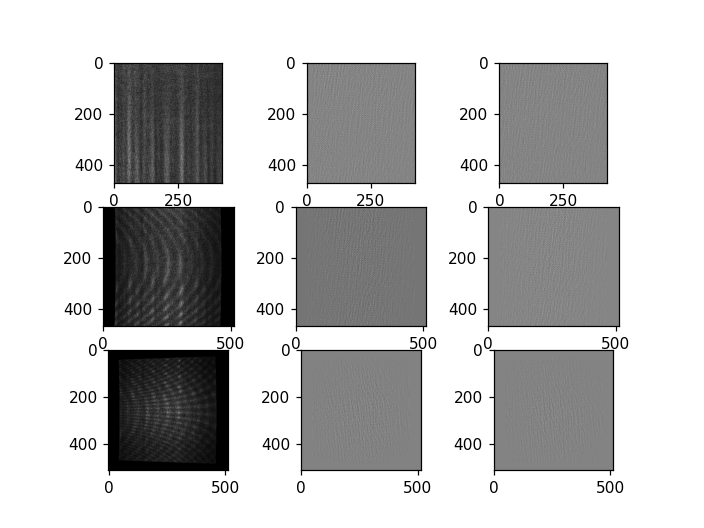

In [3]:
fig, ax= plt.subplots(3,3)
ax[0,0].imshow(np.abs(phs),cmap='gray')
ax[1,0].imshow(np.abs(imgTools.pf_rad_interp),cmap='gray')
ax[2,0].imshow(np.abs(imgTools.pf_polar),cmap='gray')

ax[0,1].imshow(np.real(phs),cmap='gray')
ax[1,1].imshow(np.real(imgTools.pf_rad_interp),cmap='gray')
ax[2,1].imshow(np.real(imgTools.pf_polar),cmap='gray')

ax[0,2].imshow(np.imag(phs),cmap='gray')
ax[1,2].imshow(np.imag(imgTools.pf_rad_interp),cmap='gray')
ax[2,2].imshow(np.imag(imgTools.pf_polar),cmap='gray')



In [4]:
print(img_pf.max())
print(img_pf.min())

27.086379126623747
0.00010643200098733089


<IPython.core.display.Javascript object>


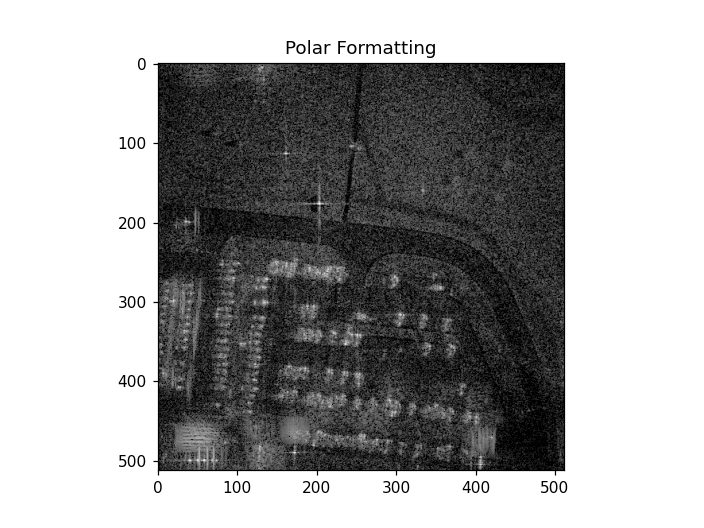

Text(0.5, 1.0, 'Polar Formatting')

In [5]:
plt.figure()
imgTools.imshow(img_pf, dB_scale = [-30,0])
plt.title('Polar Formatting')


Calculating backprojection for pulse 0
Calculating backprojection for pulse 50
Calculating backprojection for pulse 100
Calculating backprojection for pulse 150
Calculating backprojection for pulse 200
Calculating backprojection for pulse 250
Calculating backprojection for pulse 300
Calculating backprojection for pulse 350
Calculating backprojection for pulse 400
Calculating backprojection for pulse 450


<IPython.core.display.Javascript object>


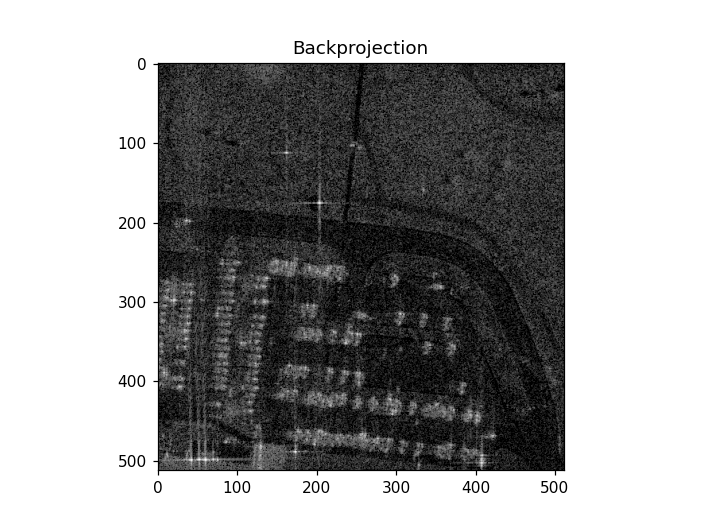

Text(0.5, 1.0, 'Backprojection')

In [6]:
#TODO: add time measurement to show speed difference
img_bp = imgTools.backprojection(phs, platform, img_plane, taylor = 20, upsample = 6,prnt=50)

plt.figure()
imgTools.imshow(img_bp, dB_scale = [-30,0])
plt.title('Backprojection')



# Other exploration

In [7]:
platform['npulses']
phs.shape 

(469, 424)

<IPython.core.display.Javascript object>


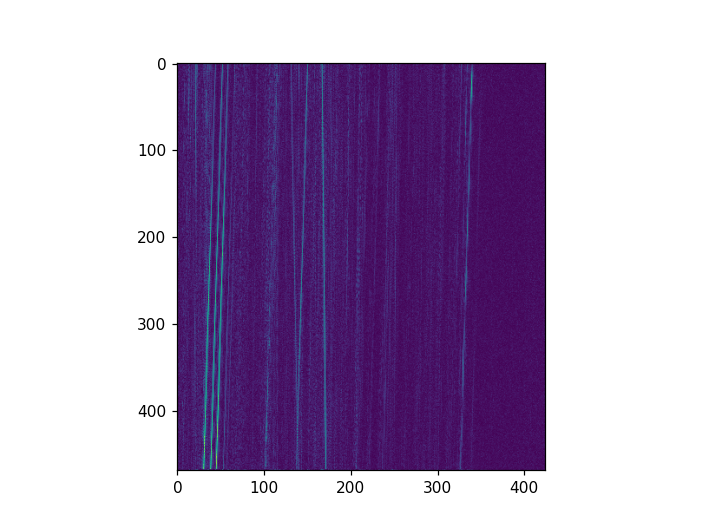

In [8]:
lazyWaterfall=signal.ft(phs) #phs is npulses by nsamples
plt.figure()
plt.imshow(np.abs(lazyWaterfall))
    
    
    